In [1]:
# 필요 패키지 import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 10월까지의 탐지 결과 통계량

In [2]:
# 파일 불러들이기
ai_detect = pd.read_excel('./data/탐지결과_6-10월.xlsx',sheet_name='sheet',
                             dtype={
                                 '탐지ID':str
                             })

C:\Users\user\anaconda3\lib\site-packages\openpyxl\styles\stylesheet.py:221: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


In [3]:
ai_detect.head(3)

,탐지ID,탐지일시,포트홀보수일시,본부,지사,노선,방향,이정,차로,위도,경도,줄눈상태
0,0051202110290210,2021-10-29 15:30:53,NaN,충북본부,제천지사,중앙선,부산,295.22,2차로,37.232944,128.079254,정상
1,0051202110290184,2021-10-29 15:04:17,NaN,충북본부,제천지사,중앙선,춘천,311.30,2차로,37.317562,127.942726,정상
2,0051202110290183,2021-10-29 15:04:00,NaN,충북본부,제천지사,중앙선,춘천,310.81,1차로,37.315632,127.947700,정상


In [4]:
## 집계 함수 생성하기 

def make_chart(temp_df,time_col,group_col):
    
    ## 필요없는 열 제거하기 
    #temp_df  = df.drop(del_col,axis=1)
    
    ## 시계열 데이터로 변환 ( #월_#주 형식으로)
    temp_df['datetime'] = pd.to_datetime(temp_df[time_col])
    temp_df['month'] = temp_df['datetime'].dt.month # 월  표시
    temp_df['day'] =  temp_df['datetime'].dt.day # 요일  표시
    

    ## 줄눈 탐지 개수 집계하기
    julnun_count_group = temp_df.groupby(group_col) # groupby (기존 + final_date여야 함)
    julnun_count = julnun_count_group['탐지ID'].count()
    julnun_df = pd.DataFrame(julnun_count.reset_index())
    julnun_df.rename(columns={'탐지ID':'탐지개수'},inplace=True)
    
    ## 줄눈 탐지 일자 집계하기 
    julnun_count_group_temp = temp_df.groupby(group_col+["month"])
    julnun_mday_temp = julnun_count_group_temp['day'].unique().map(lambda x: len(x)).reset_index()
    
    julnun_count_group2 = julnun_mday_temp.groupby(group_col)
    julnun_day_count = julnun_count_group2['day'].sum().values
    julnun_df['탐지일수'] = julnun_day_count
    
    ## 정렬하기
    julnun_df = julnun_df.sort_values(by=group_col,
                                axis=0,
                                ascending=True)    
    return julnun_df

In [5]:
#del_col = ['포트홀보수일시','줄눈상태']
time_col = '탐지일시'
group_col=['본부','지사']
aggregate_unique_df=make_chart(ai_detect,time_col,group_col)

In [6]:
aggregate_unique_df['탐지일수'].sum()

801

In [7]:
aggregate_unique_df['탐지개수'].sum()

18959

In [8]:
2162+6231+6760+2155+1651

18959

## 줄눈 실제 현황

In [9]:
real_detect_raw = pd.read_excel('./data/응력완화줄눈 현황(4835)_210331.xlsx',sheet_name='응력완화줄눈 현황',
                           skiprows=2)
real_detect = real_detect_raw.iloc[1:,0:3]

In [10]:
real_detect.head(3)

,본부,지사,노선
1,수도권,경기광주,제2중부선
2,수도권,경기광주,제2중부선
3,수도권,경기광주,제2중부선


In [11]:
real_detect['본부'] = real_detect['본부']+'본부'
real_detect['지사'] = real_detect['지사']+'지사'

In [12]:
real_group = real_detect.groupby(['본부','지사'])
real_df = real_group['노선'].count().reset_index()
real_df.rename(columns={'노선':'실제개수'},inplace=True)

In [13]:
real_df['실제개수'].sum()

4835

## 시각화

In [14]:
aggregate_unique_df['본부'].unique()

array(['강원본부', '광주전남본부', '대구경북본부', '대전충남본부', '부산경남본부', '수도권본부', '전북본부',
       '충북본부'], dtype=object)

In [15]:
# 탐지현황과 실제현황 매핑하기 
total_df = pd.merge(aggregate_unique_df,real_df,how='left')
total_df.fillna(0,inplace=True)
total_df['지사'] = total_df['지사'].apply(lambda x: x[:-2]) # 지사 빼기

In [16]:
total_df['탐지개수'].max()

3209

### 1차시도 

강원본부


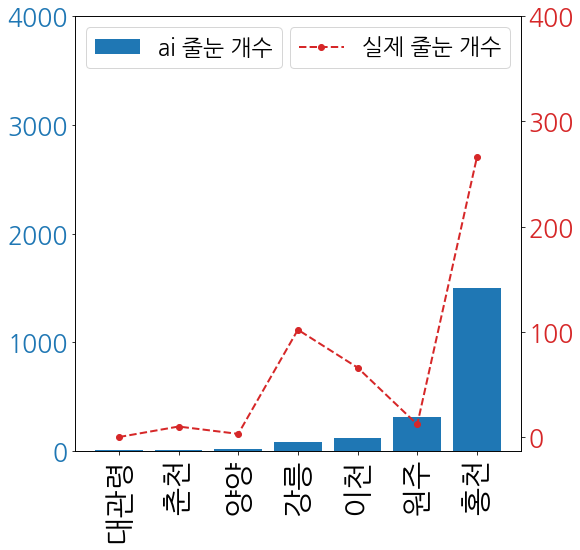

In [48]:
from matplotlib.ticker import MaxNLocator


plt.rcParams['font.family'] ='NanumGothic'
for idx,head in enumerate(total_df['본부'].unique()):
    fig,ax1 = plt.subplots(figsize=(8,8))
    
    # 해당 본부의 지사 데이터 추출하기 
    total_temp = total_df[total_df['본부']==head]
    total_temp = total_temp.sort_values(by='탐지개수',ascending=True)

    print(f"{head}")
    # 탐지현황 막대 그래프로 나타내기 
    color_1 ='tab:blue'
    bar1=ax1.bar(total_temp['지사'],total_temp['탐지개수'],color=color_1,label='ai 줄눈 개수')
    ax1.tick_params(axis='y', labelcolor=color_1)
    ax1.yaxis.set_ticks([0,1000,2000,3000,4000])
    ax1.legend(loc='upper left')
    plt.xticks(fontsize=30,rotation=90)
    plt.yticks(fontsize=25)
    plt.rc('legend',fontsize=22.5)
    
    # 실제개수 꺽은선 그래프로 나타내기 
    ax2 = ax1.twinx()
    color_2 = 'tab:red'
    ax2.plot(total_temp['지사'],total_temp['실제개수'],'ro--',linewidth=2,color=color_2,label='실제 줄눈 개수')
    ax2.tick_params(axis='y', labelcolor=color_2)
    ax2.yaxis.set_ticks([0,100,200,300,400])
    ax2.legend(loc='upper right')
    plt.yticks(fontsize=25)
    plt.rc('legend',fontsize=22.5)
    
    # 기타 설정
    plt.show()
    break

### 2차 시도

In [95]:
# 전처리 
total_df = total_df[total_df['실제개수']>0] # 0보다 큰것만 count
total_df = total_df.astype({'실제개수': 'int'})

In [96]:
total_df.head(3)

,본부,지사,탐지개수,탐지일수,실제개수
0,강원본부,강릉,83,9,102
2,강원본부,양양,18,5,3
3,강원본부,원주,315,22,12


강원본부


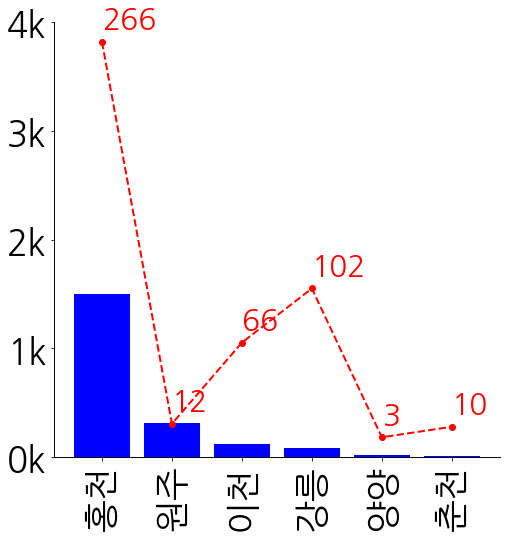

광주전남본부


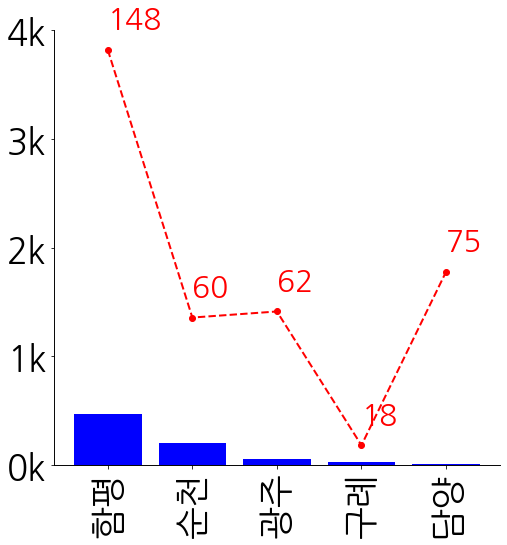

대구경북본부


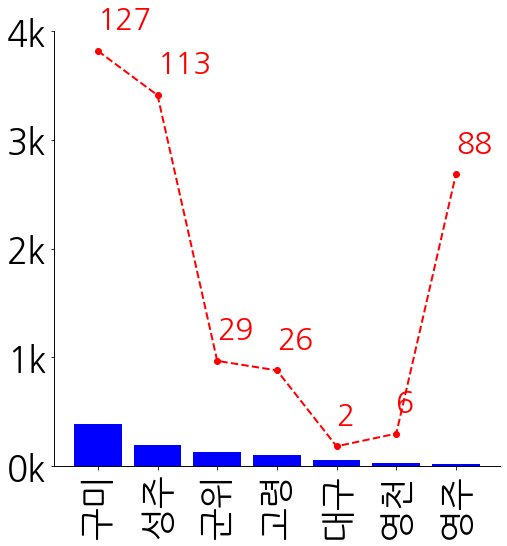

대전충남본부


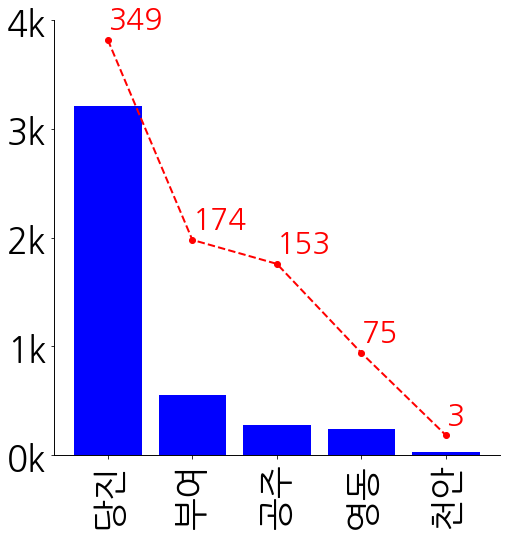

부산경남본부


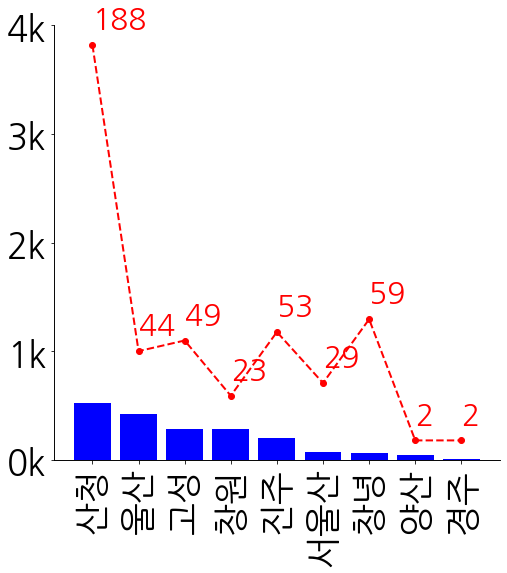

수도권본부


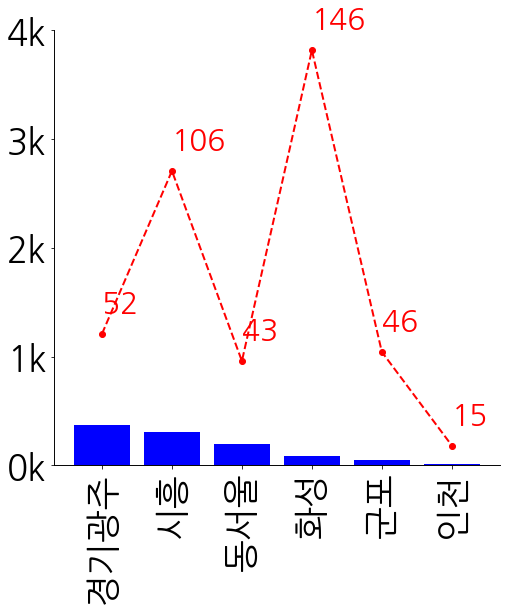

전북본부


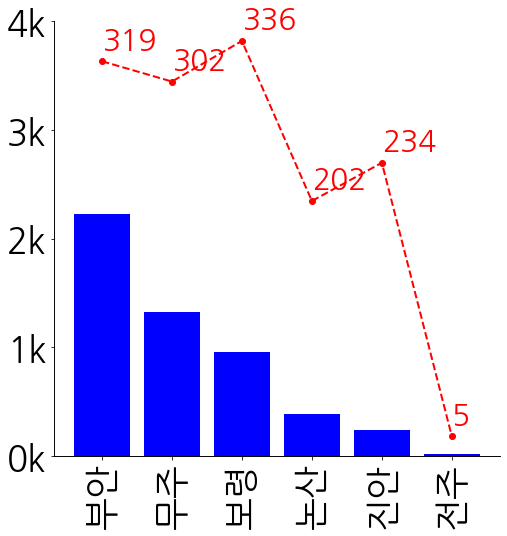

충북본부


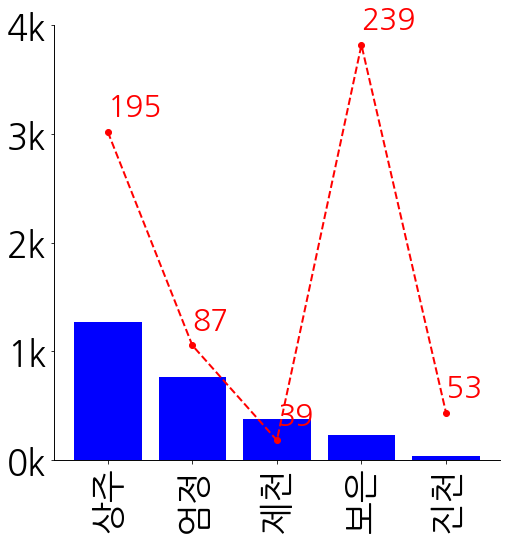

In [181]:
from matplotlib.ticker import MaxNLocator


plt.rcParams['font.family'] ='NanumGothic'
for idx,head in enumerate(total_df['본부'].unique()):
    fig,ax1 = plt.subplots(figsize=(8,8))
    
    # 해당 본부의 지사 데이터 추출하기 
    total_temp = total_df[total_df['본부']==head]
    total_temp = total_temp.sort_values(by='탐지개수',ascending=False)

    print(f"{head}")
    
    # 탐지현황 막대 그래프로 나타내기 
    color_1 ='blue'
    bar1=ax1.bar(total_temp['지사'],total_temp['탐지개수'],color=color_1)
    ax1.tick_params(axis='y')
    ax1.yaxis.set_ticks([0,1000,2000,3000,4000])
    #ax1.set_ylabel('ai 누적 줄눈 탐지 개수 (단위 : 천)',fontsize=28)
    plt.xticks(fontsize=35,rotation=90)
    plt.yticks([0,1000,2000,3000,4000],['0k','1k','2k','3k','4k'],fontsize=35)
    ax1.spines['top'].set_visible(False)
    ax1.spines['right'].set_visible(False)
    
    # 실제개수 꺽은선 그래프로 나타내기 
    ax2 = ax1.twinx()
    color_2 = 'red'
    ax2.plot(total_temp['지사'],total_temp['실제개수'],'ro--',linewidth=2,color=color_2,label='실제 줄눈 개수')
    ax2.tick_params(axis='y', labelcolor=color_2)
    ax2.axes.yaxis.set_visible(False)
    ax2.spines['top'].set_visible(False)
    ax2.spines['right'].set_visible(False)

    
    # 글자 표시 
    for idx in range(len(total_temp)):
        ax2.text(total_temp.iloc[idx,:]['지사'],total_temp.iloc[idx,4]+5,total_temp.iloc[idx,4],
                verticalalignment='bottom' , horizontalalignment='left',fontsize=30,color=color_2)

    
    # 기타 설정
    plt.show()